### Uploading data and importing libraries

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Google_Stock_Price_Test_Added.csv to Google_Stock_Price_Test_Added.csv
Saving Google_Stock_Price_Train.csv to Google_Stock_Price_Train.csv


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [3]:
df = pd.read_csv(io.BytesIO(uploaded['Google_Stock_Price_Train.csv']))
print(df)

            Date    Open    High     Low   Close      Volume
0       1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1       1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2       1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3       1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4       1/9/2012  322.04  322.29  309.46  620.76  11,688,800
...          ...     ...     ...     ...     ...         ...
1253  12/23/2016  790.90  792.74  787.28  789.91     623,400
1254  12/27/2016  790.68  797.86  787.66  791.55     789,100
1255  12/28/2016  793.70  794.23  783.20  785.05   1,153,800
1256  12/29/2016  783.33  785.93  778.92  782.79     744,300
1257  12/30/2016  782.75  782.78  770.41  771.82   1,770,000

[1258 rows x 6 columns]


In [4]:
training_set = df.iloc[:, 1: 2].values # Using the open price for prediction

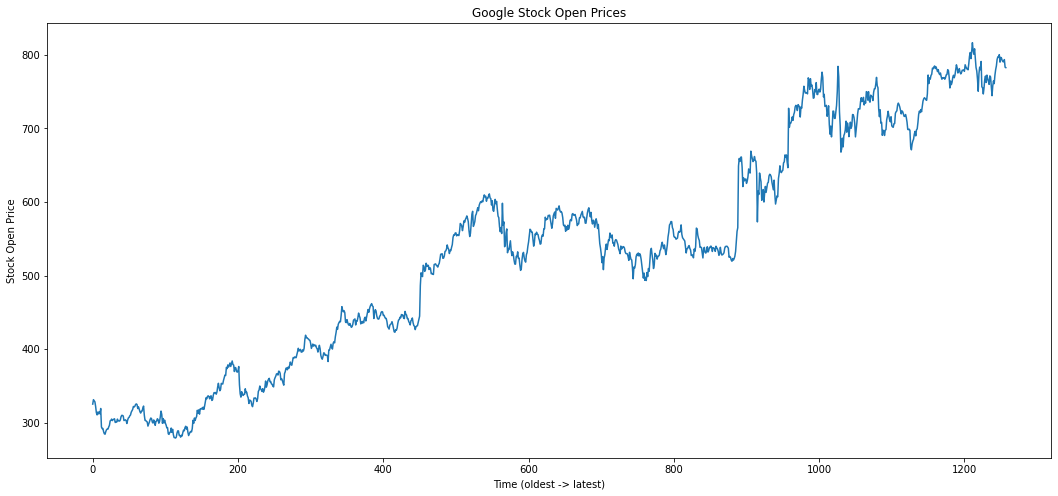

In [5]:
plt.figure(figsize=(18, 8))
plt.plot(df['Open'])
plt.title("Google Stock Open Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Open Price")
plt.show()

### Preprocessing 

In [6]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
#Creating window of 60 days for prediction
#y_train is the next day price
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60: i, 0])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
print(X_train)
print(y_train)

[[0.08581368 0.09701243 0.09433366 ... 0.07846566 0.08034452 0.08497656]
 [0.09701243 0.09433366 0.09156187 ... 0.08034452 0.08497656 0.08627874]
 [0.09433366 0.09156187 0.07984225 ... 0.08497656 0.08627874 0.08471612]
 ...
 [0.92106928 0.92438053 0.93048218 ... 0.95475854 0.95204256 0.95163331]
 [0.92438053 0.93048218 0.9299055  ... 0.95204256 0.95163331 0.95725128]
 [0.93048218 0.9299055  0.93113327 ... 0.95163331 0.95725128 0.93796041]]
[0.08627874 0.08471612 0.07454052 ... 0.95725128 0.93796041 0.93688146]


In [9]:
# Way RNN takes input 
#[Batch_size, SeqLen, num_of_dim]
X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(1198, 60, 1)


### Creating Model

In [10]:
# model = Sequential()
# #add 1st lstm layer
# # When defining the input layer of your LSTM network,
# # the network assumes you have 1 or more samples and requires
# # that you specify the number of time steps and the number of features
# # Reference used: https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/


# #Num of parameters in LSTM = 4 X (mn + m^2 + m), m: num of neurons/RNN/LSTM cells, n: input dims
# model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1))) # 4 X (100.1 + 100^2 + 100) = 40800
# model.add(Dropout(rate = 0.2)) 

# model.add(LSTM(units = 50, return_sequences = True)) # 4 X (50.100 + 50^2 + 50) = 30200
# model.add(Dropout(rate = 0.2))

# model.add(LSTM(units = 50, return_sequences = False)) # 4 X (50.50 + 50^2 + 50) = 20200
# model.add(Dropout(rate = 0.2))

# ##add output layer
# model.add(Dense(units = 1)) # 50 + 1 = 51

In [14]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape = (X_train.shape[1], 1)))

model.add(LSTM(units = 100, return_sequences = True)) 
model.add(Dropout(rate = 0.2)) 

model.add(LSTM(units = 50, return_sequences = True)) 
model.add(Dropout(rate = 0.2))

model.add(LSTM(units = 50, return_sequences = False)) 
model.add(Dropout(rate = 0.2))

##add output layer
model.add(Dense(units = 1)) # 50 + 1 = 51

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 32)            192       
                                                                 
 lstm (LSTM)                 (None, 60, 100)           53200     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            30200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)               

### Compiling and fitting model

In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [17]:
model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100)

Epoch 1/100
38/38 [==============================] - 16s 47ms/step - loss: 0.0347
Epoch 2/100
38/38 [==============================] - 2s 45ms/step - loss: 0.0065
Epoch 3/100
38/38 [==============================] - 2s 45ms/step - loss: 0.0052
Epoch 4/100
38/38 [==============================] - 2s 46ms/step - loss: 0.0045
Epoch 5/100
38/38 [==============================] - 2s 45ms/step - loss: 0.0046
Epoch 6/100
38/38 [==============================] - 2s 45ms/step - loss: 0.0055
Epoch 7/100
38/38 [==============================] - 2s 46ms/step - loss: 0.0052
Epoch 8/100
38/38 [==============================] - 2s 45ms/step - loss: 0.0048
Epoch 9/100
38/38 [==============================] - 2s 46ms/step - loss: 0.0050
Epoch 10/100
38/38 [==============================] - 2s 46ms/step - loss: 0.0047
Epoch 11/100
38/38 [==============================] - 2s 46ms/step - loss: 0.0041
Epoch 12/100
38/38 [==============================] - 2s 46ms/step - loss: 0.0038
Epoch 13/100
38/38 [====

Testing

In [18]:
test_df = pd.read_csv(io.BytesIO(uploaded['Google_Stock_Price_Test_Added.csv']))
print(test_df)

           Date         Open         High  ...        Close     Volume Unnamed: 6
0    01-03-2017   778.810000   789.630000  ...   786.140000  16,57,300        NaN
1    01-04-2017   788.360000   791.340000  ...   786.900000  10,73,000        NaN
2    01-05-2017   786.080000   794.480000  ...   794.020000  13,35,200        NaN
3    01-06-2017   795.260000   807.900000  ...   806.150000  16,40,200        NaN
4    01-09-2017   806.400000   809.970000  ...   806.650000  12,72,400        NaN
..          ...          ...          ...  ...          ...        ...        ...
140  25-06-2018  1143.599976  1143.910034  ...  1124.810059    2157300        NaN
141  26-06-2018  1128.000000  1133.209961  ...  1118.459961    1563200        NaN
142  27-06-2018  1121.339966  1131.836060  ...  1103.979980    1293900        NaN
143  28-06-2018  1102.089966  1122.310059  ...  1114.219971    1072400        NaN
144  29-06-2018  1120.000000  1128.227051  ...  1115.650024    1315100        NaN

[145 rows x 7 c

In [19]:
real_stock_price = test_df.iloc[:, 1: 2].values

In [20]:
dataset_total = pd.concat((df['Open'],test_df['Open']), axis = 0)

In [21]:
# input for prediction from 60 days before the actual test set
input_for_pred = dataset_total[len(dataset_total)-len(test_df)- 60: ].values 

In [22]:
print(input_for_pred.shape)

(205,)


In [23]:
input_for_pred = input_for_pred.reshape(-1, 1)
print(input_for_pred.shape)

(205, 1)


In [24]:
# Min-max scaling the test data
input_for_pred = sc.transform(input_for_pred)


In [25]:
X_test = []
for i in range(60, len(input_for_pred)): 
    X_test.append(input_for_pred[i-60: i, 0])

X_test = np.array(X_test)
#make numpy array as 3D , adding num of indicator
X_test = np.reshape(X_test, newshape = (X_test.shape[0],  
                        X_test.shape[1], 1))

In [26]:
print(X_test.shape)

(145, 60, 1)


### Prediction using model

In [27]:
predicted_stock_price = model.predict(X_test)

In [28]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

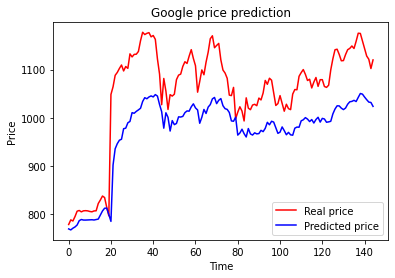

In [29]:
plt.plot(real_stock_price, color='red', label='Real price')
plt.plot(predicted_stock_price, color='blue', label='Predicted price')
plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()